In [21]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_5 import make_model
import porepy as pp

model = make_model(
    {
        "geometry": 5,
        "grid_refinement": 1,
        "solver": 3,
        'steady_state': True,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e+00 (days)
Temperature: 393.00, 393.00
sticking: 131, sliding: 0, open: 0


In [2]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 9
)

IndexError: list index out of range

In [ ]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)

(5643, 5643)

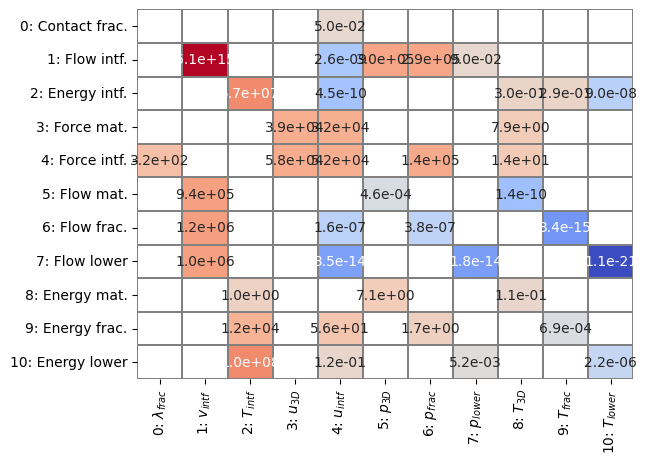

In [22]:
J = model.bmat[:]
J.plot_max()
J.shape

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 0.64
KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with one step of iterative refinement when needed
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization UPPER
    Preconditioner for the Schur complement formed from Sp, an assembled approximation to S, which uses A00's block diagonal's inverse
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
   

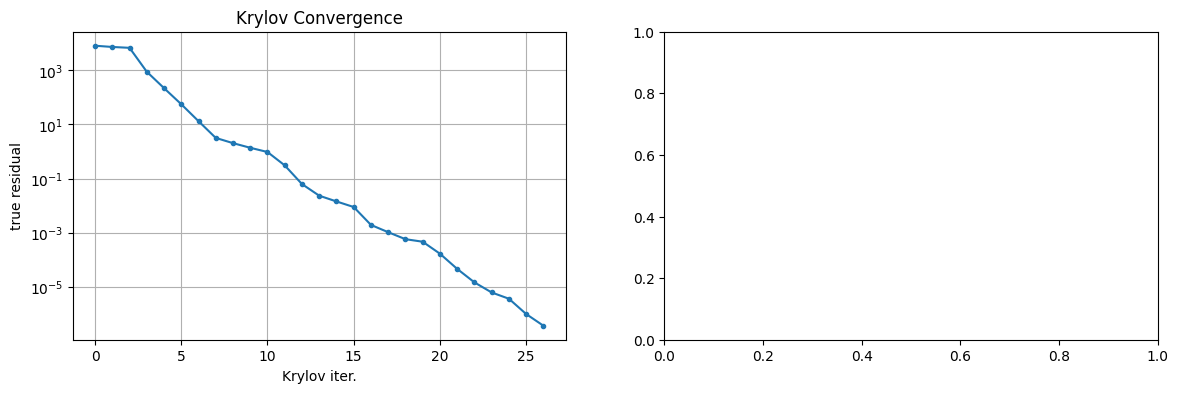

In [24]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *
from full_petsc_solver import *

contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]
scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # 'ksp_max_it': 120,
            "ksp_type": "gmres",
            # "ksp_monitor": None,
            # 'ksp_gmres_modifiedgramschmidt': None,
            # 'ksp_gmres_cgs_refinement_type': 'refine_always',
        },
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            subsolver_options={
                "pc_type": "pbjacobi",
            },
            tmp_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                subsolver_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    subsolver_options={
                        # 'pc_type': 'ksp',
                        # 'sub_ksp_type': 'gmres',
                        # 'sub_ksp_max_it': 10,
                        "pc_type": "hypre",
                        "pc_hypre_type": "boomeramg",
                        "pc_hypre_boomeramg_strong_threshold": 0.7,
                        "pc_hypre_boomeramg_smooth_type": "Euclid",
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "ksp_type": "preonly",
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                        },
                        others_options={
                            "ksp_type": "preonly",
                            "pc_type": "none",
                        },
                        cpr_options={
                            "pc_composite_pcs": "fieldsplit,ilu",
                        },
                    ),
                ),
            ),
        ),
    ),
)

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)